In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size=32
Z_dim=100
fixed_noise=torch.randn(32,Z_dim,1,1).to(device)

class conv_block(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, stride, padding):
        super(conv_block, self).__init__()

        self.conv=nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2))


    def forward(self,x):
        return self.conv(x)




class Discriminator(nn.Module):
    def __init__(self,in_channels, hidden_features=[64,128,256]):
        super(Discriminator, self).__init__()

        self.features=hidden_features
        self.layers=nn.ModuleList()

        #adding first conv layer in the module list it does not have a Batch normalization
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(in_channels, self.features[0], kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2)
                )
            )

        #adding hidden layers
        for i in range(len(self.features)-1):
            self.layers.append(conv_block(self.features[i],self.features[i+1], 4, 2, 1))

        #adding the final layer
        self.layers.append(
            nn.Sequential(
                nn.Conv2d(self.features[-1], 1, kernel_size=4, stride=2, padding=0),
                nn.Sigmoid()
                )
            )


    def forward(self,x):
        for i in self.layers:
#             print(x.shape)
            x=i(x)
        return x


# modelD=Discriminator(1)
# print(modelD)


class transpose_conv_block(nn.Module):
    def __init__(self,in_channels, out_channels, kernel_size, stride, padding):
        super(transpose_conv_block, self).__init__()

        self.conv=nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())


    def forward(self,x):
        return self.conv(x)



class Generator(nn.Module):
    def __init__(self,Z_dim, out_channels, hidden_features=[512,256,128]):
        super(Generator, self).__init__()

        self.features=hidden_features
        self.layers=nn.ModuleList()

        #adding first conv layer in the module list it does not have a Batch normalization
        self.layers.append(
                nn.ConvTranspose2d(Z_dim, self.features[0], kernel_size=4, stride=1, padding=0)
            )

        #adding hidden layers
        for i in range(len(self.features)-1):
            self.layers.append(transpose_conv_block(self.features[i],self.features[i+1], 4, 2, 1))

        #adding the final layer
        self.layers.append(
            nn.Sequential(
                transpose_conv_block(self.features[-1], out_channels, kernel_size=4, stride=2, padding=1),
#                 nn.Tanh()
                )
            )


    def forward(self,x):
        for i in self.layers:
#             print(x.shape)
            x=i(x)
        return x


# modelD=Generator(100,1)
# print(modelD)

In [ ]:
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([
#     transforms.Resize(64),
     transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# # Load the test set
# testset = torchvision.datasets.MNIST(root='./data', train=True,
#                                        download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [ ]:
modelG=Generator(100,3).to(device)
modelD=Discriminator(3).to(device)
optimizerG=torch.optim.Adam(modelG.parameters(), lr=2e-4, betas=(0.5,0.999))
optimizerD=torch.optim.Adam(modelD.parameters(), lr=2e-4, betas=(0.5,0.999))
lossFunction=nn.BCELoss()

def GenerateImages(fixed_noise,ep):
    fakes=modelG(fixed_noise)
    images_np = np.transpose(fakes.cpu().detach().numpy(), (0, 2, 3, 1))
    fig, axs = plt.subplots(4, 8, figsize=(20, 10))
    axs = axs.ravel()
    for i in range(images_np.shape[0]):
        axs[i].imshow(images_np[i])
        axs[i].axis('off')
    # plt.show()
    plt.savefig(f'{ep}_GI.png')
    plt.close('all')

genLos=[]
disLos=[]
def train(epoch=25):
    genSum=0
    disSum=0
    for ep in range(epoch):
        for i, (img,_) in enumerate(train_loader):
            #input for the discriminator
            img=img.to(device)
            # input for the generator
            noise=torch.randn(batch_size, Z_dim, 1, 1).to(device)

            #Generating the image from the noise
            imgG=modelG(noise)

            #calculating the loss for the image in the distribution
            imgD=modelD(img).reshape(-1)
            lossD=lossFunction(imgD,torch.ones_like(imgD))
            disSum+=lossD.item()

            #calculating the loss for the generated image
            fake=modelD(imgG).reshape(-1)
            lossFake=lossFunction(fake,torch.zeros_like(fake))
            genSum+=lossFake.item()

            #optimizing the discriminator
            modelD.zero_grad()
            total_loss=(lossFake+lossD)/2
            total_loss.backward(retain_graph=True)
            optimizerD.step()

            #optimizing the generator
            output=modelD(imgG).reshape(-1)
            lossG=lossFunction(output,torch.ones_like(output))
            modelG.zero_grad()
            lossG.backward()
            optimizerG.step()
        genLos.append(genSum/(len(train_loader)*batch_size))
        disLos.append(disSum/(len(train_loader)*batch_size))
        print(genLos[-1], disLos[-1])

        torch.save(modelG.state_dict(), f'Generator')
        torch.save(modelD.state_dict(), f'Discriminator')
        # GenerateImages(fixed_noise,ep+1)
        print(f'{ep+1} epoch Finished')

In [ ]:
#generated images before training
# GenerateImages(fixed_noise,0)
train(epoch=50)

0.006797527566359105 0.029776092247485696
1 epoch Finished
0.013482970290895378 0.05955642549069604
2 epoch Finished
0.02019244439137822 0.0893374536751328
3 epoch Finished
0.026950715570898294 0.11911287322945498
4 epoch Finished
0.0337956572185084 0.14889110108719505
5 epoch Finished
0.04051303861514377 0.17867162497922712
6 epoch Finished
0.047284958676017355 0.20844967369709977
7 epoch Finished
0.05406582016487125 0.23822641168600062
8 epoch Finished
0.06081296850406396 0.26800364675149274
9 epoch Finished
0.06752647975875602 0.29778183331583186
10 epoch Finished
0.07430622635691672 0.3275582831905903
11 epoch Finished
0.08108747381671086 0.3573371102116997
12 epoch Finished
0.08782633848179082 0.38711458378097835
13 epoch Finished
0.09457221847999976 0.4168904333739462
14 epoch Finished
0.10130114329833435 0.44667041064576696
15 epoch Finished
0.10809248786089526 0.47644730205322905
16 epoch Finished
0.11481009527977726 0.5062221950074981
17 epoch Finished
0.12155420192554879 0.53

In [ ]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy.stats import entropy
from torchvision import transforms
import matplotlib.pyplot as plt




tran = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Resize((299, 299)),
])

class CustomDataset(Dataset):
    # Implement a Dataset class that returns your generated images
    def __init__(self, device, Z_dim, transform, path='/content/Generator'):
      self.model=Generator(100,3).to(device)
      self.model.load_state_dict(torch.load(path))
      self.Z_dim=Z_dim
      self.transform=transform

    def __len__(self):
      return 1000

    def __getitem__(self, index):
      # Z_dim=100
      noise=torch.randn(1,self.Z_dim,1,1).to(device)
      fake=modelG(noise)
      return self.transform(fake[0])




def inception_score(genLoader, splits=10):
    # Load Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()

    if torch.cuda.is_available():
        inception_model = inception_model.cuda()

    def get_pred(x):
        with torch.no_grad():
            x = inception_model(x)
            return F.softmax(x, dim=1).data.cpu().numpy()

    preds = []

    for batch in genLoader:
        batch = batch.cuda() if torch.cuda.is_available() else batch
        pred_batch = get_pred(batch)
        preds.append(pred_batch)

    preds = np.concatenate(preds, axis=0)
    N = preds.shape[0]

    # Now compute the mean KL-divergence for splits
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# Example usage:
# Assuming `generated_images` is your dataset of images
# inception_score_value = inception_score(generated_images)




In [ ]:
genertorDataset=CustomDataset(device, Z_dim=100, transform=tran)
genloader = torch.utils.data.DataLoader(genertorDataset, batch_size=batch_size, shuffle=True)
inception_score(genloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(3.1191945, 0.16878758)

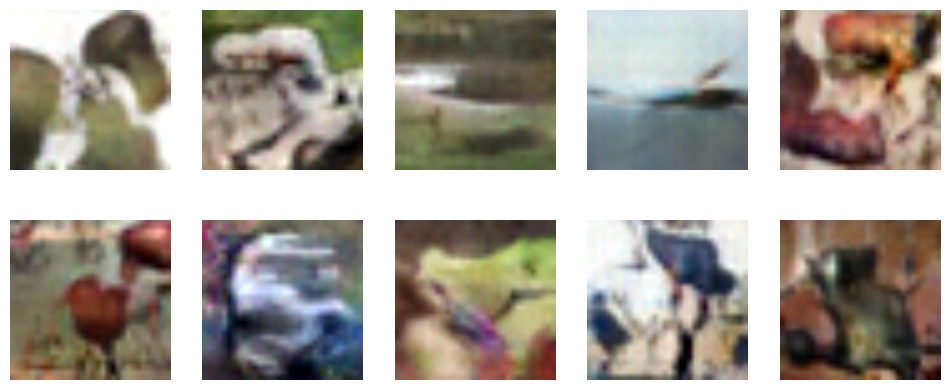

In [ ]:
fig,axes=plt.subplots(2,5, figsize=(12,5))
for i in range(2):
  for j in range(5):
    tgen=genertorDataset[i+j]
    tgen=tgen.cpu().detach().numpy()
    axes[i][j].imshow(np.transpose(tgen,(1,2,0)))
    axes[i][j].axis('off')
plt.show()

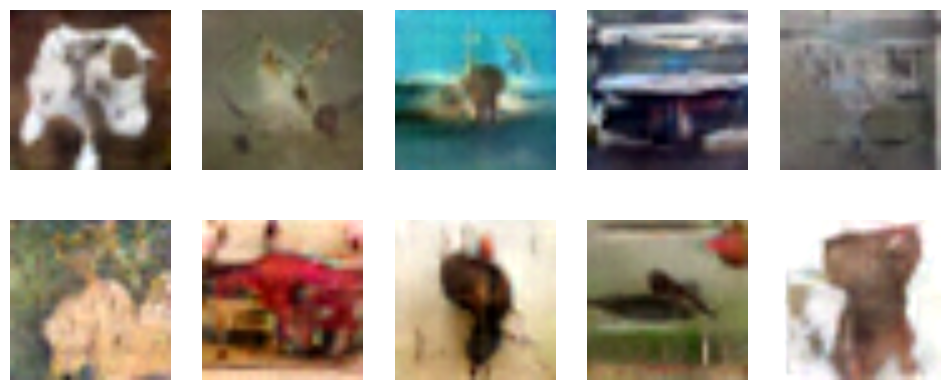

In [ ]:
genertorDataset=CustomDataset(device, Z_dim=100, transform=tran)
fig,axes=plt.subplots(2,5, figsize=(12,5))
for i in range(2):
  for j in range(5):
    tgen=genertorDataset[i+j]
    tgen=tgen.cpu().detach().numpy()
    axes[i][j].imshow(np.transpose(tgen,(1,2,0)))
    axes[i][j].axis('off')
plt.show()

In [ ]:
genertorDataset=CustomDataset(device, Z_dim=100, transform=tran)
genloader = torch.utils.data.DataLoader(genertorDataset, batch_size=batch_size, shuffle=True)
inception_score(genloader)

(3.1583905, 0.2036456)